In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 10 * u.h
n_obs = 100
l = 0.1
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(index=2.22, amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_=l * u.Unit("TeV-1"), alpha = 1)
#model_simu = PowerLawSpectralModel(index=2.22, amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV)

print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 4378 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 7697 
    Total predicted counts          : 7642.60
    Total off counts                : 22278.00

    Total background counts         : 4455.60

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 40.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 438 ms, sys: 1.6 ms, total: 439 ms
Wall time: 440 ms


Text(0, 0.5, 'No. of observations')

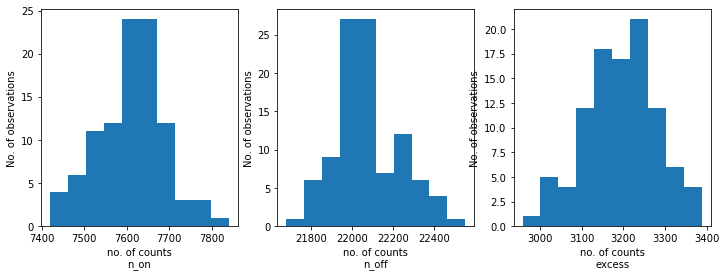

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [15]:
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV

spectra = ExpCutoffPowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_=0 * u.Unit("TeV-1"), alpha = 1)
#spectra = PowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV)

model_0 = SkyModel(spectral_model=spectra)

dataset_stacked.models = model_0
print(dataset_stacked.livetime)


1000.0 h


In [16]:
dataset_stacked.parameters["lambda_"].frozen = True
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

In [17]:
print(result_stacked.parameters.to_table())
print(result_stacked)
TS0 = result_stacked.total_stat

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.355e+00 1.607e-03                nan nan  False
amplitude 1.010e-12 2.891e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 0.000e+00 0.000e+00          TeV-1 nan nan   True
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : 5430.94



In [18]:
dataset_stacked.parameters["lambda_"].frozen = False
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

In [19]:
print(result_stacked.parameters.to_table())
print(result_stacked)
TS1 = result_stacked.total_stat

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.222e+00 2.687e-03                nan nan  False
amplitude 1.285e-12 6.008e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 9.852e-02 1.819e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 89
	total stat : 40.84



In [20]:
TS0 - TS1

5390.098373663302

In [21]:
np.sqrt(TS0 - TS1)

73.41728933748033

In [22]:
profile = stacked_fit.stat_profile(parameter="index")

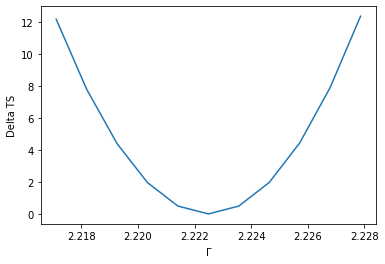

In [23]:
total_stat = result_stacked.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

In [24]:
profile

{'values': array([2.21711382, 2.21818882, 2.21926381, 2.2203388 , 2.22141379,
        2.22248878, 2.22356377, 2.22463877, 2.22571376, 2.22678875,
        2.22786374]),
 'stat': array([52.99730139, 48.63482855, 45.23340689, 42.79769969, 41.33239376,
        40.84219947, 41.33185087, 42.80610579, 45.26974591, 48.72757685,
        53.1844283 ])}